# Basic GP, Latent, Normal likelihood

In [24]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as tt
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm
np.random.seed(505)

# define gp, true parameter values
with pm.Model() as model:
    l = 0.15
    tau = 2.0 
    cov = tau * pm.gp.cov.RBF(1, l)

n = 30 
X = np.sort(np.random.rand(n))[:,None]
K = theano.function([], cov.K(X, X))()

# generate fake data from GP with white noise (with variance sigma2)
sigma2 = 0.1 
y = np.random.multivariate_normal(np.zeros(n), K + sigma2 * np.eye(n))
f_init = np.random.multivariate_normal(np.zeros(n), K)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: covariance is not positive-semidefinite.


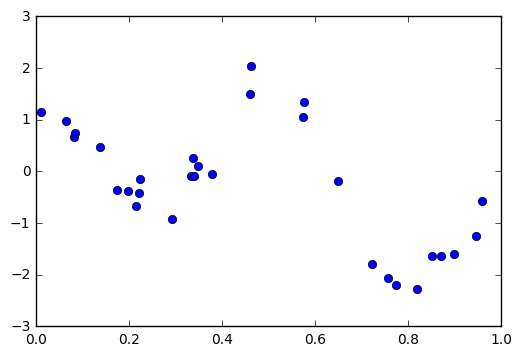

In [25]:
plt.plot(X, y, 'o')

In [26]:
# infer gp parameter values
with pm.Model() as model:
    l = pm.HalfCauchy('l', 5, testval=0.15)
    sigma2 = pm.HalfCauchy('sigma2', 5, testval=0.1)
    tau = pm.HalfCauchy('tau', 5, testval=2)

    f_cov = tau * pm.gp.cov.RBF(1, l)
    f = pm.gp.GP('f', mu=0.0, cov=f_cov.K(X,X) + 1e-5 * tt.eye(n), shape=n, testval=f_init)
   
    n_cov = sigma2 * tt.eye(n)
    y_obs = pm.gp.GP('y_obs', mu=f, cov=n_cov, observed=y)

In [ ]:
with model:
    step1 = pm.HamiltonianMC(f, step_scale=0.002, path_length=1, scaling=np.ones(n))
    step2 = pm.Slice([l, sigma2, tau])
    trace = pm.sample(200, init='map', step=[step1, step2])

 44%|████▎     | 87/200 [01:01<01:22,  1.36it/s]

In [ ]:
plt.plot(X.flatten(), trace["f"].T, "midnightblue", alpha=0.1);
plt.plot(X,y, 'ko', mec="white")

In [ ]:
pm.traceplot(trace, varnames=['l', 'tau', 'sigma2']);